In [1]:
import os
import numpy as np
import requests
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras import Model
from keras.layers import Input, Layer, TextVectorization, Embedding, Bidirectional, LSTM, Concatenate, Dense

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
# Load data
sick_train = ("https://raw.githubusercontent.com/alvations/stasis/master/SICK-data/SICK_train.txt")
sick_trial = ("https://raw.githubusercontent.com/alvations/stasis/master/SICK-data/SICK_trial.txt")
train_data = requests.get(sick_train).text
trial_data = requests.get(sick_trial).text
data = train_data + trial_data                         # Combine train and trial data, we will split them again later

split_data = data.split("\n")[1:]
split_data = [n.split("\t") for n in split_data if len(n) > 0]
split_data = [n for n in split_data if len(n) == 5]

# print(split_data[0])

all_text = []
labels = []
sent_a = []
sent_b = []

for sample in split_data:
  if sample[4] == 'ENTAILMENT':      
    all_text.append(sample[1])       
    sent_a.append(sample[1])
    all_text.append(sample[2])       
    sent_b.append(sample[2])
    labels.append(0)
  elif sample[4] == 'CONTRADICTION': 
    all_text.append(sample[1])       
    sent_a.append(sample[1])
    all_text.append(sample[2])       
    sent_b.append(sample[2])
    labels.append(1)

print("Number of samples =", len(sent_a))
print("Number of sentences =", len(all_text))
print("Some sample labels = ", labels[20:40])

Number of samples = 2182
Number of sentences = 4364
Some sample labels =  [1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0]


In [4]:
# Create the vectorizer, vocabulary and inverse vocabulary using all_text
max_length=32
vectorizer = tf.keras.layers.TextVectorization(max_tokens=20000, output_sequence_length=max_length)
text = tf.data.Dataset.from_tensor_slices(all_text).batch(256)
vectorizer.adapt(text)
vocab = vectorizer.get_vocabulary()              # Vocabulary of all words in order of frequency
#print(vocab)
word_index = dict(zip(vocab, range(len(vocab)))) # Inverse vocabulary

print("Vocab length:", len(vocab))
print("Word at index 221:", vocab[221])
print("The index of 'jersey':", word_index['jersey'])

Vocab length: 1705
Word at index 221: jersey
The index of 'jersey': 221


In [5]:
# Map our vocabulary to the glove.6B.100d embedding

if 0:   # change 1 to 0
  glove_path = '/content/drive/My Drive/CS577/Final Project/'                  # location for Kael         
  glove_file = '/content/drive/My Drive/CS577/Final Project/glove.6B.100d.txt'
elif 1:
  glove_path = '/content/drive/MyDrive/'                                      # location for Aman         
  glove_file = '/content/drive/MyDrive/glove.6B.100d.txt'
else:
  get_glove = ("https://resources.oreilly.com/conferences/natural-language-processing-with-deep-learning/-/raw/master/data/glove.6B.100d.txt")
  glove_file = requests.get(get_glove).text
 
embedding_index = {}
with open(glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embedding_index[word] = coefs

print("Number of word vectors:", len(embedding_index))

Number of word vectors: 400000


In [6]:
num_tokens = len(vocab) + 2
embedding_dim = 100
match = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        match += 1
    else:
        misses += 1
        
print(embedding_matrix.shape)
print("Number of matches:", match)
print("Number of misses:", misses)

(1707, 100)
Number of matches: 1686
Number of misses: 19


In [7]:
# Vectorize both lists of sentences
sent_a_vect = vectorizer(sent_a)
sent_b_vect = vectorizer(sent_b)

if 0:
  print("Longest A:", np.max(np.count_nonzero(sent_a_vect,axis=1)))
  print("Longest B:", np.max(np.count_nonzero(sent_b_vect,axis=1)))
  print("Location of longest A:", np.argmax(np.count_nonzero(sent_a_vect,axis=1)))
  print("Location of longest B:", np.argmax(np.count_nonzero(sent_b_vect,axis=1)))
print((sent_a_vect[767].shape))
print(len(sent_a))
print(type(sent_b_vect[0]))

(32,)
2182
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [8]:
# Build an embedding layer using our embedding matrix
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False)

In [9]:
# Split into training, validation and test sets (total samples = 2182)
n_train = 1800
n_val = 200           # if (n_train + n_val) = 2182 there is no test data
print("n_train + n_val =", n_train+n_val)
#sent_a_vect
#sent_b_vect

x_train_a = np.array(sent_a_vect[0:n_train])
x_train_b = np.array(sent_b_vect[0:n_train])
y_train = np.array(labels[0:n_train])
x_val_a = np.array(sent_a_vect[n_train:n_train+n_val])
x_val_b = np.array(sent_b_vect[n_train:n_train+n_val])
y_val = np.array(labels[n_train:n_train+n_val])
x_test_a = np.array(sent_a_vect[n_train+n_val:])
x_test_b = np.array(sent_b_vect[n_train+n_val:])
y_test = np.array(labels[n_train+n_val:])

print("n train =", len(y_train))
print("n val =", len(y_val))

#print(len(y_test))
#print(x_train_a[0])
#print(len(x_train_b))

n_train + n_val = 2000
n train = 1800
n val = 200


In [10]:
# Manhattan distance loss function
import keras.backend as K

class MalLSTM(Layer):
    def __init__(self, **kwargs):
        super(MalLSTM, self).__init__(**kwargs)
        self.result = None

    def build(self, input_shape):
        super(MalLSTM, self).build(input_shape)

    def call(self, x, **kwargs):
        self.result = K.exp(-K.sum(K.abs(x[0] - x[1]), axis=1, keepdims=True))
        return self.result

    def compute_output_shape(self, input_shape):
        return K.int_shape(self.result)

In [16]:
# Build the model
senA_inp = Input(shape=(32), dtype='int32')
senB_inp = Input(shape=(32), dtype='int32')

senA_embed = embedding_layer(senA_inp)
senB_embed = embedding_layer(senB_inp)

lstm = Bidirectional(LSTM(256,dropout=0.1))
senA_lstm_out = lstm(senA_embed)
senB_lstm_out = lstm(senB_embed)

model_A = Model(inputs=senA_inp, outputs = senA_lstm_out)
model_B = Model(inputs=senB_inp, outputs = senB_lstm_out)

malstm_distance = MalLSTM()([senA_lstm_out, senB_lstm_out])

model_full = Model(inputs=[senA_inp, senB_inp], outputs=malstm_distance)

model_full.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 32, 100)      170700      ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 512)         731136      ['embedding[2][0]',        

In [12]:
# Build checkpoints and compile model
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(
        # filepath = '/content/drive/My Drive/CS577/Final Project/sematic-Manhattan-loss_{loss:.3f}_val_acc{val_accuracy:.3f}.h5',     # Save to final project folder in drive
        filepath='/content/Sematic-loss_{loss:.3f}_val_acc{accuracy:.3f}.h5',
        monitor = 'val_accuracy',
        save_best_only = True
        ),
     tf.keras.callbacks.ReduceLROnPlateau(
         monitor = 'loss',
         factor = 0.1,
         patience = 3,
         min_lr = 1e-5
     ),
    ]

model_full.compile(
    loss = tf.keras.losses.mean_squared_error,
    optimizer= tf.keras.optimizers.Adam(1e-3),
	  metrics=["accuracy"]
)

In [13]:
# Train the model
epochs = 40

history = model_full.fit(x = [x_train_a, x_train_b], y = y_train, validation_data=([x_val_a, x_val_b], y_val),
    batch_size=64, epochs=epochs, callbacks=my_callbacks)

Epoch 1/40
29/29 [==============================] - 10s 69ms/step - loss: 0.3014 - accuracy: 0.6756 - val_loss: 0.1881 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 2/40
29/29 [==============================] - 1s 23ms/step - loss: 0.1999 - accuracy: 0.7467 - val_loss: 0.1370 - val_accuracy: 0.8350 - lr: 0.0010
Epoch 3/40
29/29 [==============================] - 1s 22ms/step - loss: 0.1471 - accuracy: 0.8350 - val_loss: 0.1208 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 4/40
29/29 [==============================] - 1s 22ms/step - loss: 0.1276 - accuracy: 0.8589 - val_loss: 0.1148 - val_accuracy: 0.8550 - lr: 0.0010
Epoch 5/40
29/29 [==============================] - 1s 24ms/step - loss: 0.1194 - accuracy: 0.8661 - val_loss: 0.1056 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 6/40
29/29 [==============================] - 1s 23ms/step - loss: 0.1106 - accuracy: 0.8778 - val_loss: 0.1081 - val_accuracy: 0.8850 - lr: 0.0010
Epoch 7/40
29/29 [==============================] - 0s 17ms/step - loss: 0.

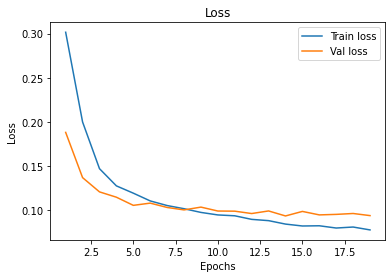

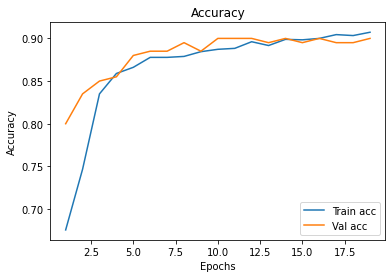

In [14]:
# Plot training process
dict1 = history.history
loss = dict1['loss']
val_loss = dict1['val_loss']
accuracy = dict1['accuracy']
val_accuracy = dict1['val_accuracy']
epochs = range(1,len(loss)+1)

plt.plot(epochs,loss, label='Train loss')
plt.plot(epochs,val_loss,label='Val loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")
plt.show()

#print("\n")

plt.clf()
plt.plot(epochs,accuracy, label='Train acc')
plt.plot(epochs,val_accuracy,label='Val acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

In [15]:
# Evaluate on test data
test_out = model_full.predict([x_test_a, x_test_b])
predictions = np.round(test_out)
test_diff = predictions.T-y_test
test_errors = np.count_nonzero(test_diff)
test_acc = (1-test_errors/len(predictions))*100
print("Test accuracy =", np.round(test_acc, 1), "%")
print()

id_disp = 10
num_pred = 10

print("Sent A:", sent_a[id_disp])
print("Sent B:", sent_b[id_disp])
print("y pred:", predictions[id_disp])           # remember 0 means entailment and 1 means contradiction
print("y true:", y_test[id_disp])

6/6 [==============================] - 3s 8ms/step
Test accuracy = 85.2 %

Sent A: Four girls are doing backbends and playing in the garden
Sent B: Four girls are doing backbends and playing outdoors
y pred: [0.]
y true: 0
